In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import skimage
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
TRAINING_NAME = "rgbd_data"
DIR_TO_IMAGES= "/datadrive/RGBD_data/lineside_data_jpg_sections/"
DIR_TO_DSMS = "/datadrive/RGBD_data/lineside_data_dsm_sections/"

In [3]:
import glob
import gdal
import pandas as pd

In [4]:
df = pd.read_csv("/datadrive/images_defects_df.csv")

In [5]:
df["defect_polygon_list"] = df["defect_polygon"].apply(lambda x: x.replace("[[",""))
df["defect_polygon_list"] = df["defect_polygon_list"].apply(lambda x: x.replace("]]",""))
df["defect_polygon_list"] = df["defect_polygon_list"].apply(lambda x: x.split("], ["))
df["defect_polygon_list"] = df["defect_polygon_list"].apply(lambda x: [[int(l) for l in f.lstrip().rstrip().split(", ")]  for f in x])

In [ ]:
LX Decking Area                            17
Culvert Area                               15
LX Trespass Guard                          15
LX Extent                                  14
Catch / Trap Point Area                    13
Insufficient Source Data                   12
Light Maintenance Depot Area                7
Fixed Diamond Area                          7
Fixed Diamond Single Slip Area              4
Switch Diamond Area                         4
Fixed Diamond Double Slip Area              4
Gabion Walls                                3

In [6]:
not_taking = ["Obscured Polygon","Insufficient Source Data","Turnout Area","Ballast"]

In [7]:
df = df[~df.defect_name.isin(not_taking)]

In [8]:
# df= df.iloc[100:200,:]

In [9]:
CLASSES_TO_TAKE = df.defect_name.unique()

In [10]:
len(CLASSES_TO_TAKE)

41

In [11]:
CLASSES_TO_TAKE

array(['Cutting Extent', 'Cutting Area', 'Troughing', 'Cabinet',
       'Gantry Extent', 'Retaining Wall', 'Bridge Wing Wall Extent',
       'Off Track Detail Polygon', 'Bridge Area', 'Embankments Extent',
       'Embankment Side Area 2', 'Watercourse', 'Wall',
       'Embankment Side Area 1', 'On Track Detail Polygon',
       'At Grade Earthworks Cutting Area', 'At Grade Earthworks Extent',
       'Lineside Building', 'Platform', 'Ramp Area', 'GSMR Cabinet',
       'NR Boundary Buildings', 'Cantilever Extent', 'Car Park',
       'Hardstanding', 'Canopy', 'Gabion Walls',
       'Catch / Trap Point Area', 'Station Building', 'Pond/Lake',
       'Bridge Ramp Extent', 'Culvert Area', 'Fixed Diamond Area',
       'LX Extent', 'LX Trespass Guard', 'LX Decking Area',
       'Switch Diamond Area', 'Light Maintenance Depot Area',
       'Access Walkways/Staging Platform Area',
       'Fixed Diamond Double Slip Area', 'Fixed Diamond Single Slip Area'],
      dtype=object)

In [10]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = TRAINING_NAME

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(CLASSES_TO_TAKE)  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 512)  # anchor side in pixels
    MEAN_PIXEL = [123.7 ,116.8 ,103.9, 36.4]
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100
    IMAGE_CHANNEL_COUNT = 4           
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 900
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                54
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [11]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [12]:
all_images = glob.glob("/datadrive/RGBD_data/lineside_data_jpg_sections/*.jpg")

In [13]:
npis = set([DIR_TO_IMAGES+f.split("/")[-1].replace(".npy",".jpg") for f in glob.glob("/datadrive/RGBD_data/lineside_data_dsm_sections/*.npy")])

In [14]:
all_images = list(set([DIR_TO_IMAGES+f for f in df.images.unique()]) & (set(all_images) & npis))

In [15]:
valid_names = np.random.choice(all_images, 10,replace=False)
train_names = set(all_images) - set(valid_names)

In [18]:
len(train_names)/2

863.0

In [16]:
def img_to_annotation(labels,filename):
    
    img1 = np.zeros((1024,1024))
#     labels = labels
    name = filename.replace(".jpg","")
#     print(name)
    target_mat = []
    class_matrix = []
    
    for lab in labels.iterrows():
        inst = ((np.array(lab[1]["defect_polygon_list"])/2048.)*1024.).astype(np.int32)
        
        img = img1.copy()
        
        cv2.fillPoly(img, np.int32([inst]),255)
        anno_matrix = np.zeros((1024,1024),"uint8")
        red_channel_zero = np.where(img == 255)
        points_red_channel_zero = []
        for r in range(len(red_channel_zero[0])):
            points_red_channel_zero.append((red_channel_zero[0][r],red_channel_zero[1][r]))

        final = points_red_channel_zero

        import collections
        annotation_points_index_list =  [item for item, count in collections.Counter(final).items() if count == 1]
        for i in range(len(annotation_points_index_list)):
            anno_matrix[annotation_points_index_list[i][0],annotation_points_index_list[i][1]] = 1
        target_mat.append(anno_matrix)
        class_matrix.append(lab[1]["defect_name"])
    else:
        pass
    
    if (len(class_matrix) == 0):
        pass
    elif (len(class_matrix) ==1):
        mask = target_mat[0]
        mask = np.reshape(mask,(1024,1024,1))
        mask = np.array(mask)
     
    else:
        mask = np.concatenate((np.expand_dims(target_mat[0],axis=-1), np.expand_dims(target_mat[1],axis=-1)),axis =-1)
        for j in range(2,len(class_matrix)):
            mask = np.concatenate((mask,np.expand_dims(target_mat[j],-1)),axis = -1)        
    return mask,class_matrix

In [17]:
class AsphaltShapeCracksDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_crack(self, dataset_dir,subset):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        for a_id, asset in enumerate(CLASSES_TO_TAKE):
            self.add_class(TRAINING_NAME, a_id+1, asset)

      
        assert subset in ["train", "val"]
        if subset == "val":
            image_ids = valid_names
        elif subset == "train":
            image_ids = train_names
        height, width = (1024,1024)
        
        for image_id in image_ids:
            self.add_image(
                TRAINING_NAME,
                image_id=image_id,
                path=os.path.join(DIR_TO_IMAGES, image_id))

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == TRAINING_NAME:
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)            

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
#         print(info["id"])
        df_annotations = df[df["images"] == info["id"].split("/")[-1]]

        mask, class_ids = img_to_annotation(df_annotations,info["id"])    
        class_ids = np.array(class_ids)
        new_class_ids = []
        for c in class_ids:
            new_class_ids.append(self.class_names.index(c))
        return mask.astype(np.bool), np.array(new_class_ids).astype(np.int32)  
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        depth_mask_name = DIR_TO_DSMS + self.image_info[image_id]['path'].split("/")[-1].replace(".jpg",".npy")
        depth_mask = np.expand_dims(np.load(depth_mask_name),axis=2)
        depth_mask = np.where(depth_mask == -9999,0, depth_mask )
#         print(image.shape)
#         print(depth_mask.shape)
        image = np.concatenate([image, depth_mask],axis=-1)

        # If grayscale. Convert to RGB for consistency.
#         if image.ndim != 3:
#             image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
#         if image.shape[-1] == 4:
#             image = image[..., :3]
#         image = skimage.transform.resize(image, (1024,1024), preserve_range=True)
        return image

In [18]:

dataset_train = AsphaltShapeCracksDataset()

dataset_train.load_crack(DIR_TO_IMAGES, subset="train")

dataset_train.prepare()

# validation dataset
dataset_val = AsphaltShapeCracksDataset()

dataset_val.load_crack(DIR_TO_IMAGES, subset="val")

dataset_val.prepare()

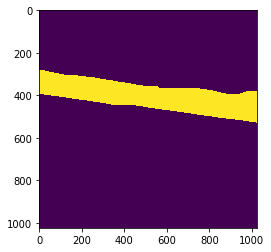

In [144]:
image_id = np.random.choice(np.arange(len(valid_names)),1)[0]
plt.imshow(dataset_train.load_mask(image_id)[0][:,:,0])

In [145]:
dataset_train.load_mask(image_id)[1]

array([17, 16, 17, 16,  3,  3], dtype=int32)

In [19]:
# from tqdm import tqdm
# o_mean = []
# for i in tqdm(range(len(train_names))):
#     o_mean.append(dataset_train.load_image(i)[:,:,3].mean())

In [20]:
# np.mean(o_mean) # 36.4

In [28]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,model_dir="/datadrive/logs")

In [29]:
model.load_weights("/datadrive/mask_rcnn_lineside_only_gantry_0026-Copy1.h5",exclude=['conv1','mrcnn_bbox_fc','mrcnn_class_logits','mrcnn_mask'])

In [30]:
# augmentation = imgaug.augmenters.Sometimes(1,imgaug.augmenters.OneOf(
#                                             [
#                                             imgaug.augmenters.Fliplr(1), 
#                                             imgaug.augmenters.Flipud(1)
#                                              ]
#                                         )
#                                    )

model.train(dataset_train, dataset_val, 
            learning_rate=0.0001, 
            epochs=1, 
            layers='all'
#             ,augmentation=augmentation
           )

model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=15, 
            layers='all'
#             ,augmentation=augmentation
           )

model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=1, 
            layers='heads'
#             ,augmentation=augmentation
           )


model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=17+15, 
            layers='all'
#             ,augmentation=augmentation
           )

model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=1+17+15, 
            layers='heads'
#             ,augmentation=augmentation
           )


model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=15+1+17+15, 
            layers='all'
#             ,augmentation=augmentation
           )

model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=25+1+15+17+15, 
            layers='all'
#             ,augmentation=augmentation
           )



Starting at epoch 0. LR=0.0001

Checkpoint Path: /datadrive/logs/rgbd_data20191211T0757/mask_rcnn_rgbd_data_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b 

/data/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
900/900 [==============================] - 1418s 2s/step - loss: 5.3199 - rpn_class_loss: 0.3219 - rpn_bbox_loss: 3.0311 - mrcnn_class_loss: 0.5598 - mrcnn_bbox_loss: 0.6997 - mrcnn_mask_loss: 0.7074 - val_loss: 5.0533 - val_rpn_class_loss: 0.2562 - val_rpn_bbox_loss: 3.0455 - val_mrcnn_class_loss: 0.4945 - val_mrcnn_bbox_loss: 0.6112 - val_mrcnn_mask_loss: 0.6459


Starting at epoch 1. LR=0.001

Checkpoint Path: /datadrive/logs/rgbd_data20191211T0757/mask_rcnn_rgbd_data_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2

Epoch 2/15
900/900 [==============================] - 1391s 2s/step - loss: 4.5107 - rpn_class_loss: 0.2048 - rpn_bbox_loss: 2.6169 - mrcnn_class_loss: 0.5357 - mrcnn_bbox_loss: 0.6093 - mrcnn_mask_loss: 0.5440 - val_loss: 5.0462 - val_rpn_class_loss: 0.2491 - val_rpn_bbox_loss: 3.0547 - val_mrcnn_class_loss: 0.5078 - val_mrcnn_bbox_loss: 0.6095 - val_mrcnn_mask_loss: 0.6251
Epoch 3/15
900/900 [==============================] - 1173s 1s/step - loss: 3.8509 - rpn_class_loss: 0.1718 - rpn_bbox_loss: 2.1659 - mrcnn_class_loss: 0.5142 - mrcnn_bbox_loss: 0.5287 - mrcnn_mask_loss: 0.4703 - val_loss: 3.4970 - val_rpn_class_loss: 0.1419 - val_rpn_bbox_loss: 1.9065 - val_mrcnn_class_loss: 0.3896 - val_mrcnn_bbox_loss: 0.5302 - val_mrcnn_mask_loss: 0.5288
Epoch 4/15
900/900 [==============================] - 1182s 1s/step - loss: 3.9228 - rpn_class_loss: 0.1744 - rpn_bbox_loss: 2.2083 - mrcnn_class_loss: 0.5424 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.4572 - val_loss: 3.2915 - val_rpn_clas

Epoch 16/32
900/900 [==============================] - 1452s 2s/step - loss: 3.3729 - rpn_class_loss: 0.1366 - rpn_bbox_loss: 1.7232 - mrcnn_class_loss: 0.6013 - mrcnn_bbox_loss: 0.4707 - mrcnn_mask_loss: 0.4411 - val_loss: 3.0169 - val_rpn_class_loss: 0.1784 - val_rpn_bbox_loss: 1.2408 - val_mrcnn_class_loss: 0.5664 - val_mrcnn_bbox_loss: 0.4989 - val_mrcnn_mask_loss: 0.5324
Epoch 17/32
900/900 [==============================] - 1203s 1s/step - loss: 3.0623 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 1.5602 - mrcnn_class_loss: 0.5468 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.4163 - val_loss: 3.7975 - val_rpn_class_loss: 0.1078 - val_rpn_bbox_loss: 2.2220 - val_mrcnn_class_loss: 0.4960 - val_mrcnn_bbox_loss: 0.4897 - val_mrcnn_mask_loss: 0.4820
Epoch 18/32
900/900 [==============================] - 1227s 1s/step - loss: 3.1023 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 1.6478 - mrcnn_class_loss: 0.5113 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.4049 - val_loss: 3.1266 - val_rpn_c

Epoch 34/48
900/900 [==============================] - 1421s 2s/step - loss: 3.7742 - rpn_class_loss: 0.1681 - rpn_bbox_loss: 2.0344 - mrcnn_class_loss: 0.6397 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.4437 - val_loss: 3.1925 - val_rpn_class_loss: 0.2015 - val_rpn_bbox_loss: 1.5074 - val_mrcnn_class_loss: 0.5345 - val_mrcnn_bbox_loss: 0.4476 - val_mrcnn_mask_loss: 0.5015
Epoch 35/48
900/900 [==============================] - 1191s 1s/step - loss: 3.2167 - rpn_class_loss: 0.1401 - rpn_bbox_loss: 1.6906 - mrcnn_class_loss: 0.5740 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.4071 - val_loss: 2.7837 - val_rpn_class_loss: 0.1500 - val_rpn_bbox_loss: 1.2403 - val_mrcnn_class_loss: 0.4196 - val_mrcnn_bbox_loss: 0.4796 - val_mrcnn_mask_loss: 0.4942
Epoch 36/48
900/900 [==============================] - 1209s 1s/step - loss: 3.1661 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 1.6985 - mrcnn_class_loss: 0.5371 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.4006 - val_loss: 3.7177 - val_rpn_c

Epoch 49/73
900/900 [==============================] - 1426s 2s/step - loss: 2.4153 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 1.1033 - mrcnn_class_loss: 0.5088 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.3844 - val_loss: 2.6991 - val_rpn_class_loss: 0.2054 - val_rpn_bbox_loss: 1.0681 - val_mrcnn_class_loss: 0.5014 - val_mrcnn_bbox_loss: 0.4247 - val_mrcnn_mask_loss: 0.4996
Epoch 50/73
900/900 [==============================] - 1188s 1s/step - loss: 2.3005 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.0731 - mrcnn_class_loss: 0.4792 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.3613 - val_loss: 2.9280 - val_rpn_class_loss: 0.1456 - val_rpn_bbox_loss: 1.2830 - val_mrcnn_class_loss: 0.4721 - val_mrcnn_bbox_loss: 0.4460 - val_mrcnn_mask_loss: 0.5812
Epoch 51/73
900/900 [==============================] - 1208s 1s/step - loss: 2.3195 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.1221 - mrcnn_class_loss: 0.4453 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 0.3554 - val_loss: 2.9189 - val_rpn_c

Process ForkPoolWorker-160:
Process ForkPoolWorker-163:
Process ForkPoolWorker-162:
Traceback (most recent call last):
Process ForkPoolWorker-159:
Process ForkPoolWorker-152:
Process ForkPoolWorker-161:
Process ForkPoolWorker-156:
Traceback (most recent call last):
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/process.py", 

  File "<ipython-input-17-04bb86c17a3a>", line 45, in load_mask
    mask, class_ids = img_to_annotation(df_annotations,info["id"])
  File "<ipython-input-17-04bb86c17a3a>", line 59, in load_image
    depth_mask = np.where(depth_mask == -9999,0, depth_mask )
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
Process ForkPoolWorker-154:
  File "/data/anaconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/data/home/linesidetraining/train_rgbd_data/Mask_RCNN/mrcnn/model.py", line 1220, in load_image_gt
    mask = utils.resize_mask(mask, scale, padding, crop)
  File "/data/home/linesidetraining/train_rgbd_data/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini

KeyboardInterrupt: 

  File "/data/home/linesidetraining/train_rgbd_data/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "skimage/transform/_warps_cy.pyx", line 131, in skimage.transform._warps_cy._warp_fast
  File "<ipython-input-17-04bb86c17a3a>", line 45, in load_mask
    mask, class_ids = img_to_annotation(df_annotations,info["id"])
  File "<ipython-input-16-0bfaaa28f23f>", line 26, in img_to_annotation
    for i in range(len(annotation_points_index_list)):
  File "/data/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py", line 424, in asarray
    def asarray(a, dtype=None, order=None):
KeyboardInterrupt
KeyboardInterrupt


In [46]:
df

,images,defect_name,defect_polygon,defect_polygon_list,class
0,SU910560_RGB_v2_2048_10240.jpg,Cutting Extent,"[[-10240, -2048], [-10240, -2048], [-10240, -2...","[[-10240, -2048], [-10240, -2048], [-10240, -2...",1
1,SU910560_RGB_v2_2048_10240.jpg,Cutting Area,"[[-10240, -2048], [-10240, -2048], [-10240, -2...","[[-10240, -2048], [-10240, -2048], [-10240, -2...",2
3,SU910560_RGB_v2_2048_10240.jpg,Cutting Extent,"[[-10240, -2048], [-10240, -2048], [-10240, -2...","[[-10240, -2048], [-10240, -2048], [-10240, -2...",1
4,SU910560_RGB_v2_2048_10240.jpg,Cutting Area,"[[-10240, -2048], [-10240, -2048], [-10240, -2...","[[-10240, -2048], [-10240, -2048], [-10240, -2...",2
5,SU910560_RGB_v2_2048_10240.jpg,Troughing,"[[-10240, -564], [-10240, -539], [-10240, -489...","[[-10240, -564], [-10240, -539], [-10240, -489...",3
6,SU910560_RGB_v2_2048_10240.jpg,Troughing,"[[2260, 1511], [2260, 1511], [2260, 1486], [22...","[[2260, 1511], [2260, 1511], [2260, 1486], [22...",3
7,SU910560_RGB_v2_2048_10240.jpg,Cabinet,"[[910, 1436], [910, 1436], [910, 1436], [910, ...","[[910, 1436], [910, 1436], [910, 1436], [910, ...",4
8,SU910560_RGB_v2_2048_10240.jpg,Gantry Extent,"[[810, 1186], [810, 1186], [785, 1186], [785, ...","[[810, 1186], [810, 1186], [785, 1186], [785, ...",5
9,SU910560_RGB_v2_2048_10240.jpg,Retaining Wall,"[[835, 1411], [835, 1461], [835, 1461], [935, ...","[[835, 1411], [835, 1461], [835, 1461], [935, ...",6
10,SU910560_RGB_v2_2048_10240.jpg,Cabinet,"[[885, 1436], [885, 1461], [860, 1461], [860, ...","[[885, 1436], [885, 1461], [860, 1461], [860, ...",4
